# Breakout Strategy

### Install & Load Packages

In [6]:
import sys
# !{sys.executable} -m pip install -r requirements.txt
import pandas as pd
import numpy as np
import helper
import project_helper
import project_tests

import os
import sys
module_path = os.path.abspath(os.path.join('../../lib/stockPredictor'))
if module_path not in sys.path:
    sys.path.append(module_path)
from stockPredictor import StockPredictor 

### Load Data

In [7]:
# ! npm run fetch:data
    
df_original = pd.read_csv('../../data/stock/coinbase.csv', parse_dates=['Date'], index_col=False)
df = df_original
len(df)
open = df.reset_index().pivot(index='Date', columns='Symbol', values='Open')
high = df.reset_index().pivot(index='Date', columns='Symbol', values='High')
low = df.reset_index().pivot(index='Date', columns='Symbol', values='Low')
close = df.reset_index().pivot(index='Date', columns='Symbol', values='Close')

# open = open.drop(['BCH-USD', 'XRP-USD'], axis=1)
# high = high.drop(['BCH-USD', 'XRP-USD'], axis=1)
# low = low.drop(['BCH-USD', 'XRP-USD'], axis=1)
# close = close.drop(['BCH-USD', 'XRP-USD'], axis=1)

# open = open.tail(800)
# high = high.tail(800)
# low = low.tail(800)
# close = close.tail(800)

apple_ticker = 'BTC-USD'
lookback_days =30
hold_days = 80
lookback_days_sell = 30

### View Data
To see what one of these 2-d matrices looks like, let's take a look at the closing prices matrix.

In [8]:
close.head(5)

Symbol,BCH-USD,BTC-USD,ETH-USD,LTC-USD,XRP-USD
Date,,,,,
2016-06-18,nan,758.99000000,11.64000000,nan,nan
2016-06-19,nan,768.76000000,12.35000000,nan,nan
2016-06-20,nan,703.12000000,11.81000000,nan,nan
2016-06-21,nan,667.66000000,13.89000000,nan,nan
2016-06-22,nan,604.50000000,13.18000000,nan,nan


### Stock Example
Let's see what a single stock looks like from the closing prices. For this example and future display examples in this project, we'll use Apple's stock (AAPL). If we tried to graph all the stocks, it would be too much information.

In [9]:
project_helper.plot_stock(close[apple_ticker], '{} Stock'.format(apple_ticker))

## Compute the Highs and Lows in a Window
You'll use the price highs and lows as an indicator for the breakout strategy. In this section, implement `get_high_lows_lookback` to get the maximum high price and minimum low price over a window of days. The variable `lookback_days` contains the number of days to look in the past. Make sure this doesn't include the current day.

In [10]:
def get_high_lows_lookback(high, low, lookback_days):
    """
    Get the highs and lows in a lookback window.
    
    Parameters
    ----------
    high : DataFrame
        High price for each ticker and date
    low : DataFrame
        Low price for each ticker and date
    lookback_days : int
        The number of days to look back
    
    Returns
    -------
    lookback_high : DataFrame
        Lookback high price for each ticker and date
    lookback_low : DataFrame
        Lookback low price for each ticker and date
    """
    #TODO: Implement function
    lookback_high = high.shift(1).rolling(window=lookback_days).max()
    lookback_low = low.shift(1).rolling(window=lookback_days).min()
#     print(high)
#     print(lookback_days)
#     print('********')
#     print(lookback_high)
    return lookback_high, lookback_low

project_tests.test_get_high_lows_lookback(get_high_lows_lookback)

Tests Passed


### View Data
Let's use your implementation of `get_high_lows_lookback` to get the highs and lows for the past 50 days and compare it to it their respective stock.  Just like last time, we'll use Apple's stock as the example to look at.

In [11]:
lookback_high, lookback_low = get_high_lows_lookback(high, low, lookback_days)
# project_helper.plot_high_low(
#     close[apple_ticker],
#     lookback_high[apple_ticker],
#     lookback_low[apple_ticker],
#     'High and Low of {} Stock'.format(apple_ticker))

## Compute Long and Short Signals
Using the generated indicator of highs and lows, create long and short signals using a breakout strategy. Implement `get_long_short` to generate the following signals:

| Signal | Condition |
|----|------|
| -1 | Low > Close Price |
| 1  | High < Close Price |
| 0  | Otherwise |

In this chart, **Close Price** is the `close` parameter. **Low** and **High** are the values generated from `get_high_lows_lookback`, the `lookback_high` and `lookback_low` parameters.

In [12]:
def get_long_short(close, lookback_high, lookback_low):
    """
    Generate the signals long, short, and do nothing.
    
    Parameters
    ----------
    close : DataFrame
        Close price for each ticker and date
    lookback_high : DataFrame
        Lookback high price for each ticker and date
    lookback_low : DataFrame
        Lookback low price for each ticker and date
    
    Returns
    -------
    long_short : DataFrame
        The long, short, and do nothing signals for each ticker and date
    """
    #TODO: Implement function
    short = lookback_low > close
    short = short * -1
    long =  lookback_high < close
    
    short = short.astype(np.int)
    long = long.astype(np.int)
    
#     Old Code
#     long_short = short + long
#   new code
    long_short = long

#     print(short)
#     print(long)
#     print(long_short)
    
    return long_short

# project_tests.test_get_long_short(get_long_short)

### View Data
Let's compare the signals you generated against the close prices. This chart will show a lot of signals. Too many in fact. We'll talk about filtering the redundant signals in the next problem. 

In [13]:
signal = get_long_short(close, lookback_high, lookback_low)
project_helper.plot_signal(
    close[apple_ticker],
    signal[apple_ticker],
    'Long and Short of {} Stock'.format(apple_ticker))

## Filter Signals

In [14]:
def clear_signals(signals, window_size):
    """
    Clear out signals in a Series of just long or short signals.
    
    Remove the number of signals down to 1 within the window size time period.
    
    Parameters
    ----------
    signals : Pandas Series
        The long, short, or do nothing signals
    window_size : int
        The number of days to have a single signal       
    
    Returns
    -------
    signals : Pandas Series
        Signals with the signals removed from the window size
    """
    # Start with buffer of window size
    # This handles the edge case of calculating past_signal in the beginning
    clean_signals = [0]*window_size
    
    for signal_i, current_signal in enumerate(signals):
        # Check if there was a signal in the past window_size of days
        has_past_signal = bool(sum(clean_signals[signal_i:signal_i+window_size]))
        # Use the current signal if there's no past signal, else 0/False
        clean_signals.append(not has_past_signal and current_signal)
        
    # Remove buffer
    clean_signals = clean_signals[window_size:]

    # Return the signals as a Series of Ints
    return pd.Series(np.array(clean_signals).astype(np.int), signals.index)


def filter_signals(signal, lookahead_days):
    """
    Filter out signals in a DataFrame.
    
    Parameters
    ----------
    signal : DataFrame
        The long, short, and do nothing signals for each ticker and date
    lookahead_days : int
        The number of days to look ahead
    
    Returns
    -------
    filtered_signal : DataFrame
        The filtered long, short, and do nothing signals for each ticker and date
    """
    #TODO: Implement function
#     print(lookahead_days)
    filtered_signal = signal.copy()
    for index, column in signal.iteritems():
        long = np.floor((column + 1) /2).astype(np.int)
        short = np.floor((column - 1) /-2).astype(np.int)
        long_cleared = clear_signals(long, lookahead_days)
        short_cleared = clear_signals(short, lookahead_days)
        long_short_cleared = (short_cleared * -1) + long_cleared
        filtered_signal[index] = long_short_cleared
    return filtered_signal

project_tests.test_filter_signals(filter_signals)

Tests Passed


### View Data
Let's view the same chart as before, but with the redundant signals removed.

In [15]:
signal_5 = filter_signals(signal, 5)
signal_80 = filter_signals(signal, 80)
signal_20 = filter_signals(signal, 20)
signal_50 = filter_signals(signal, 50)
# for signal_data, signal_days in [(signal_5, 5), (signal_80, 80), (signal_20, 20), (signal_50, 50)]:
#     project_helper.plot_signal(
#         close[apple_ticker],
#         signal_data[apple_ticker],
#         'Long and Short of {} Stock with {} day signal window'.format(apple_ticker, signal_days))

## Lookahead Close Prices
With the trading signal done, we can start working on evaluating how many days to short or long the stocks. In this problem, implement `get_lookahead_prices` to get the close price days ahead in time. You can get the number of days from the variable `lookahead_days`. We'll use the lookahead prices to calculate future returns in another problem.

In [16]:
def get_lookahead_prices(close, lookahead_days):
    """
    Get the lookahead prices for `lookahead_days` number of days.
    
    Parameters
    ----------
    close : DataFrame
        Close price for each ticker and date
    lookahead_days : int
        The number of days to look ahead
    
    Returns
    -------
    lookahead_prices : DataFrame
        The lookahead prices for each ticker and date
    """
    #TODO: Implement function
    
    return close.shift(-lookahead_days)

project_tests.test_get_lookahead_prices(get_lookahead_prices)

Tests Passed


### View Data
Using the `get_lookahead_prices` function, let's generate lookahead closing prices for 5, 10, and 20 days.

Let's also chart a subsection of a few months of the Apple stock instead of years. This will allow you to view the differences between the 5, 10, and 20 day lookaheads. Otherwise, they will mesh together when looking at a chart that is zoomed out.

In [17]:
lookahead_5 = get_lookahead_prices(close, 5)
lookahead_80 = get_lookahead_prices(close, 80)
lookahead_20 = get_lookahead_prices(close, 20)
lookahead_50 = get_lookahead_prices(close, 50)
# project_helper.plot_lookahead_prices(
#     close[apple_ticker].iloc[150:250],
#     [
#         (lookahead_5[apple_ticker].iloc[150:250], 5),
#         (lookahead_80[apple_ticker].iloc[150:250], 80),
#         (lookahead_20[apple_ticker].iloc[150:250], 20),
#         (lookahead_50[apple_ticker].iloc[150:250], 50)
#     ],
#     '5, 80, 20, and 50 day Lookahead Prices for Slice of {} Stock'.format(apple_ticker))

## Lookahead Price Returns
Implement `get_return_lookahead` to generate the log price return between the closing price and the lookahead price.

In [18]:
def get_return_lookahead(close, lookahead_prices):
    """
    Calculate the log returns from the lookahead days to the signal day.
    
    Parameters
    ----------
    close : DataFrame
        Close price for each ticker and date
    lookahead_prices : DataFrame
        The lookahead prices for each ticker and date
    
    Returns
    -------
    lookahead_returns : DataFrame
        The lookahead log returns for each ticker and date
    """
    #TODO: Implement function
    
    return np.log(lookahead_prices) - np.log(close)

project_tests.test_get_return_lookahead(get_return_lookahead)

Tests Passed


### View Data
Using the same lookahead prices and same subsection of the Apple stock from the previous problem, we'll view the lookahead returns.

In order to view price returns on the same chart as the stock, a second y-axis will be added. When viewing this chart, the axis for the price of the stock will be on the left side, like previous charts. The axis for price returns will be located on the right side.

In [19]:
price_return_5 = get_return_lookahead(close, lookahead_5)
price_return_80 = get_return_lookahead(close, lookahead_80)
price_return_20 = get_return_lookahead(close, lookahead_20)
price_return_50 = get_return_lookahead(close, lookahead_50)
# project_helper.plot_price_returns(
#     close[apple_ticker].iloc[150:250],
#     [
#         (price_return_5[apple_ticker].iloc[150:250], 5),
#         (price_return_80[apple_ticker].iloc[150:250], 80),
#         (price_return_20[apple_ticker].iloc[150:250], 20),
#         (price_return_50[apple_ticker].iloc[150:250], 50)
#     ],
#     '5, 10, and 20 day Lookahead Returns for Slice {} Stock'.format(apple_ticker))

## Compute the Signal Return
Using the price returns generate the signal returns.

In [20]:
def get_signal_return(signal, lookahead_returns):
    """
    Compute the signal returns.
    
    Parameters
    ----------
    signal : DataFrame
        The long, short, and do nothing signals for each ticker and date
    lookahead_returns : DataFrame
        The lookahead log returns for each ticker and date
    
    Returns
    -------
    signal_return : DataFrame
        Signal returns for each ticker and date
    """
    #TODO: Implement function
    signal_return = signal * lookahead_returns
#     print(signal_return)
    return signal_return

project_tests.test_get_signal_return(get_signal_return)

Tests Passed


### View Data
Let's continue using the previous lookahead prices to view the signal returns. Just like before, the axis for the signal returns is on the right side of the chart.

In [21]:
title_string = '{} day LookaheadSignal Returns for {} Stock'
signal_return_5 = get_signal_return(signal_5, price_return_5)
signal_return_80 = get_signal_return(signal_80, price_return_80)
signal_return_20 = get_signal_return(signal_20, price_return_20)
signal_return_50 = get_signal_return(signal_50, price_return_50)
project_helper.plot_signal_returns(
    close[apple_ticker],
    [
        (signal_return_5[apple_ticker], signal_5[apple_ticker], 5),
        (signal_return_80[apple_ticker], signal_80[apple_ticker], 80),
        (signal_return_20[apple_ticker], signal_20[apple_ticker], 20),
        (signal_return_50[apple_ticker], signal_50[apple_ticker], 50)
    ],
    [
    title_string.format(5, apple_ticker), 
     title_string.format(80, apple_ticker),
     title_string.format(20, apple_ticker), 
     title_string.format(50, apple_ticker)
    ])

## Test for Significance
### Histogram
Let's plot a histogram of the signal return values.

In [22]:
project_helper.plot_signal_histograms(
    [signal_return_5, signal_return_80, signal_return_20, signal_return_50],
    'Signal Return',
    ('5 Days', '80 Days', '20 Days', '50 Days'))

### Question: What do the histograms tell you about the signal returns?

*#TODO: Put Answer In this Cell*

The histograms are not normally distributed, they are skewed to the right. This is happening because of outliers, which are appearing to the right side as well. Once the outliers are removed below, the histograms are much closer to resembling a normal distribution.

## Outliers
You might have noticed the outliers in the 10 and 20 day histograms. To better visualize the outliers, let's compare the 5, 10, and 20 day signals returns to normal distributions with the same mean and deviation for each signal return distributions.

In [23]:
project_helper.plot_signal_to_normal_histograms(
    [signal_return_5, signal_return_80, signal_return_20, signal_return_50],
    'Signal Return',
    ('5 Days', '80 Days', '20 Days', '50 Days'))

## Kolmogorov-Smirnov Test
While you can see the outliers in the histogram, we need to find the stocks that are causing these outlying returns. We'll use the Kolmogorov-Smirnov Test or KS-Test. This test will be applied to teach ticker's signal returns where a long or short signal exits.

In [24]:
# Filter out returns that don't have a long or short signal.
long_short_signal_returns_5 = signal_return_5[signal_5 != 0].stack()
long_short_signal_returns_80= signal_return_80[signal_80 != 0].stack()
long_short_signal_returns_20 = signal_return_20[signal_20 != 0].stack()
long_short_signal_returns_50 = signal_return_50[signal_50 != 0].stack()

# Get just ticker and signal return
long_short_signal_returns_5 = long_short_signal_returns_5.reset_index().iloc[:, [1,2]]
long_short_signal_returns_5.columns = ['ticker', 'signal_return']
long_short_signal_returns_80 = long_short_signal_returns_80.reset_index().iloc[:, [1,2]]
long_short_signal_returns_80.columns = ['ticker', 'signal_return']
long_short_signal_returns_20 = long_short_signal_returns_20.reset_index().iloc[:, [1,2]]
long_short_signal_returns_20.columns = ['ticker', 'signal_return']
long_short_signal_returns_50 = long_short_signal_returns_50.reset_index().iloc[:, [1,2]]
long_short_signal_returns_50.columns = ['ticker', 'signal_return']

# View some of the data
long_short_signal_returns_20.head(5)

,ticker,signal_return
0,BTC-USD,-0.01355730
1,ETH-USD,0.02201347
2,BTC-USD,0.08186673
3,LTC-USD,-0.02010118
4,BTC-USD,0.00777047


This gives you the data to use in the KS-Test.

Now it's time to implement the function `calculate_kstest` to use Kolmogorov-Smirnov test (KS test) between a normal distribution and each stock's signal returns. Run KS test on a normal distribution against each stock's signal returns. Use [`scipy.stats.kstest`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.kstest.html#scipy-stats-kstest) perform the KS test. When calculating the standard deviation of the signal returns, make sure to set the delta degrees of freedom to 0.

For this function, we don't reccommend you try to find a vectorized solution. Instead, you should iterate over the [`groupby`](https://pandas.pydata.org/pandas-docs/version/0.21/generated/pandas.DataFrame.groupby.html) function.

In [25]:
from scipy.stats import kstest
# import scipy as sc
# print (sc.__version__)

def calculate_kstest(long_short_signal_returns):
    """
    Calculate the KS-Test against the signal returns with a long or short signal.
    
    Parameters
    ----------
    long_short_signal_returns : DataFrame
        The signal returns which have a signal.
        This DataFrame contains two columns, "ticker" and "signal_return"
    
    Returns
    -------
    ks_values : Pandas Series
        KS static for all the tickers
    p_values : Pandas Series
        P value for all the tickers
    """
    #TODO: Implement function
#     print(long_short_signal_returns)
    grouped_returns = long_short_signal_returns.groupby('ticker')
#     print(long_short_signal_returns)
    ks_values = pd.Series()
    p_values = pd.Series()
    
    returns = long_short_signal_returns.signal_return
    mean = long_short_signal_returns.mean()
    std = long_short_signal_returns.std(ddof=0)
    normal_args = (mean,std)
#     print(mean)
#     print(std)
    for index, group in grouped_returns:
#         print(index)
#         print(group)
#         print(index)
        ks_value, p_value = kstest(group.signal_return, 'norm', normal_args)
        ks_values.set_value(index, ks_value)
        p_values.set_value(index, p_value)
        
#     print(ks_values)
#     print(p_values)
    return ks_values, p_values


project_tests.test_calculate_kstest(calculate_kstest)


Tests Passed


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:41: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



### View Data
Using the signal returns we created above, let's calculate the ks and p values.

In [26]:
ks_values_5, p_values_5 = calculate_kstest(long_short_signal_returns_5)
ks_values_80, p_values_80 = calculate_kstest(long_short_signal_returns_80)
ks_values_20, p_values_20 = calculate_kstest(long_short_signal_returns_20)
ks_values_50, p_values_50 = calculate_kstest(long_short_signal_returns_50)

print('ks_values_5')
print(ks_values_5.head(10))
print('p_values_5')
print(p_values_5.head(10))

ks_values_5
BCH-USD   0.17674100
BTC-USD   0.16079290
ETH-USD   0.13750721
LTC-USD   0.24227784
XRP-USD   0.57092403
dtype: float64
p_values_5
BCH-USD   0.96400977
BTC-USD   0.22687615
ETH-USD   0.56692987
LTC-USD   0.08908868
XRP-USD   0.18939185
dtype: float64


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:40: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:41: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



## Find Outliers
With the ks and p values calculate, let's find which symbols are the outliers. Implement the `find_outliers` function to find the following outliers:
- Symbols that pass the null hypothesis with a p-value less than `pvalue_threshold`.
- Symbols that with a KS value above `ks_threshold`.

In [27]:
def find_outliers(ks_values, p_values, ks_threshold, pvalue_threshold=0.05):
    """
    Find outlying symbols using KS values and P-values
    
    Parameters
    ----------
    ks_values : Pandas Series
        KS static for all the tickers
    p_values : Pandas Series
        P value for all the tickers
    ks_threshold : float
        The threshold for the KS statistic
    pvalue_threshold : float
        The threshold for the p-value
    
    Returns
    -------
    outliers : set of str
        Symbols that are outliers
    """
    #TODO: Implement function
    p_value_outliers = p_values[p_values < pvalue_threshold].index
    ks_outliers = ks_values[ks_values > ks_threshold].index
    outliers = set(p_value_outliers).intersection(set(ks_outliers))
    return outliers


project_tests.test_find_outliers(find_outliers)

Tests Passed


### View Data
Using the `find_outliers` function you implemented, let's see what we found.

In [28]:
ks_threshold = 0.8
outliers_5 = find_outliers(ks_values_5, p_values_5, ks_threshold)
outliers_80 = find_outliers(ks_values_80, p_values_80, ks_threshold)
outliers_20 = find_outliers(ks_values_20, p_values_20, ks_threshold)
outliers_50 = find_outliers(ks_values_50, p_values_50, ks_threshold)

outlier_tickers = outliers_5.union(outliers_80).union(outliers_20).union(outliers_50)
print('{} Outliers Found:\n{}'.format(len(outlier_tickers), ', '.join(list(outlier_tickers))))

0 Outliers Found:



### Show Significance without Outliers
Let's compare the 5, 10, and 20 day signals returns without outliers to normal distributions. Also, let's see how the P-Value has changed with the outliers removed.

In [29]:
good_tickers = list(set(close.columns) - outlier_tickers)

project_helper.plot_signal_to_normal_histograms(
    [signal_return_5[good_tickers], signal_return_80[good_tickers], 
     signal_return_20[good_tickers], signal_return_50[good_tickers]],
    'Signal Return Without Outliers',
    ('5 Days', '80 Days', '20 Days', '50 Days'))

### Net Profit Projection

In [30]:
title_string = '{} day LookaheadSignal Returns for {} Stock'
project_helper.plot_signal_returns(
    close[apple_ticker],
    [
#         (signal_return_5[apple_ticker], signal_5[apple_ticker], 5),
        (signal_return_80[apple_ticker], signal_80[apple_ticker], 80),
#         (signal_return_20[apple_ticker], signal_20[apple_ticker], 20),
        (signal_return_50[apple_ticker], signal_50[apple_ticker], 50)
    ],
    [
#     title_string.format(5, apple_ticker), 
     title_string.format(80, apple_ticker),
#      title_string.format(20, apple_ticker), 
     title_string.format(50, apple_ticker)
    ])

In [34]:
# PREP FOR NET PROFIT CALCULATION
signa_non_filter = get_long_short(close, lookback_high, lookback_low)
# predicted = signa_non_filter[apple_ticker].values
predicted = signal_80[apple_ticker].values
net_profit = pd.DataFrame()
net_profit['Timestamp'] = close.index
net_profit['Close'] = close[apple_ticker].values
# CREATE ACTIONS
net_profit['predicted'] = predicted + 1

# TIME EXIT
net_profit['sells'] = (predicted * -1 )
net_profit.sells = net_profit.sells.shift(hold_days)
net_profit.fillna(method='bfill', inplace=True)
net_profit.sells = net_profit.sells.astype(int)
net_profit.predicted = net_profit.predicted + net_profit.sells

# TREND REVERSAL EXIT
# lookback_high, lookback_low = get_high_lows_lookback(high, low, lookback_days_sell)
# net_profit['lowestLow'] = lookback_low[apple_ticker].values
# net_profit['sells'] = net_profit.Close < net_profit.lowestLow
# net_profit.sells = net_profit.sells.astype(int)
# net_profit['sells'] = net_profit.sells * -1
# net_profit.predicted = net_profit.predicted + net_profit.sells

# SMA FILTER
# net_profit['SMA100'] = net_profit.Close.rolling(window=100, min_periods=1).mean()
# net_profit.predicted = (net_profit.Close > net_profit.SMA100).astype(int) * net_profit.predicted

# CALCULATE
p = StockPredictor(pd.DataFrame(), 'index')
p.calculate_net_profit_hold(net_profit, 100, 0)
p.result

# VIEW BUYS AND SELLS
net_profit[(net_profit['predicted'] != 1)]


,Timestamp,Close,predicted,sells,buyAmount,sellAmount
78,2016-09-04,611.92000000,2,0,0.00000000,0.16342005
158,2016-11-23,741.52000000,0,-1,121.17923912,0.00000000
166,2016-12-01,754.00000000,2,0,0.00000000,0.16071517
246,2017-02-19,1059.88000000,0,-1,170.33879570,0.00000000
247,2017-02-20,1089.82000000,2,0,0.00000000,0.15629994
327,2017-05-11,1837.93000000,0,-1,287.26834043,0.00000000
334,2017-05-18,1899.16000000,2,0,0.00000000,0.15126074
414,2017-08-06,3222.22000000,0,-1,487.39537054,0.00000000
415,2017-08-07,3398.23000000,2,0,0.00000000,0.14342625
495,2017-10-26,5891.61000000,0,-1,845.01150276,0.00000000


/usr/local/lib/python3.5/dist-packages/pandas/plotting/_core.py:1716: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



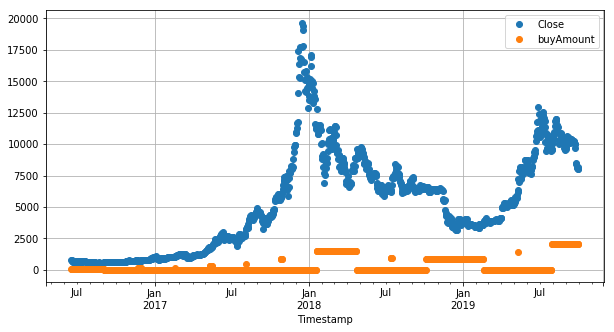

In [32]:
p.plot_profit(net_profit)